In [5]:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [7]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test =  x_test / 255

In [8]:
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

print(y_train.shape, 'train samples')
print(y_test.shape, 'test samples')

(60000, 784) train samples
(10000, 784) test samples
(60000,) train samples
(10000,) test samples


In [4]:
class NeuralNetwork:

    def __init__(self, x_train, y_train, x_val, y_val, layers, alpha=0.1, iterations=100, act='relu', ini='zeros'):
        self.x_train = x_train
        self.y_train = y_train
        self.layers = layers
        self.alpha = alpha
        self.iterations = iterations
        self.ini = ini
        self.params = self.init_params()
        self.act = act
        self.loss = []
        self.val_loss = []
        self.x_val = x_val
        self.y_val = y_val
        self.accuracy = []
        self.val_accuracy = []

    def cross_entropy(self, Y, A):
        m = Y.size
        cost = -1 / m * np.sum(Y * np.log(A))
        return cost

    def activation(self, Z, deriv=False):
        if self.act == 'relu':
            if deriv:
                return Z > 0
            else:
                return np.maximum(Z, 0)
            
        elif self.act == 'sigmoid':
            if deriv:
                return self.sigmoid(Z) * (1 - self.sigmoid(Z))
            else:
                return self.sigmoid(Z)
            
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def init_params(self):
        layers_dims = [784] + self.layers + [10]
        parameters = {}

        for l in range(1, len(layers_dims)):
            if self.ini == 'zeros':
                parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
                parameters['b' + str(l)] = np.ones((layers_dims[l], 1))
            elif self.ini == 'random':
                parameters['W' + str(l)] = np.random.rand(layers_dims[l], layers_dims[l-1]) - 0.5
                parameters['b' + str(l)] = np.random.rand(layers_dims[l], 1) - 0.5
            elif self.ini == 'normal':
                parameters['W' + str(l)] = np.random.normal(0, 1, size=(layers_dims[l], layers_dims[l-1]))
                parameters['b' + str(l)] = np.random.normal(0, 1, size=(layers_dims[l], 1))

        return parameters

    def softmax(self, Z):
        Z /= np.max(Z)
        A = np.exp(Z) / sum(np.exp(Z))
        return A

    def one_hot(self, Y):

        one_hot_Y = np.zeros((Y.size, Y.max() + 1))
        one_hot_Y[np.arange(Y.size), Y] = 1
        one_hot_Y = one_hot_Y.T
        
        return one_hot_Y

    def get_predictions(self, A2):
        return np.argmax(A2, 0)

    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y.flatten()) / Y.size

    def forward_prop(self, x_train):

        A_prev = x_train.T
        As = []
        Zs = []

        for l in range(1, len(self.layers) + 2):

            Z = self.params['W' + str(l)].dot(A_prev) + self.params['b' + str(l)]
            A = self.activation(Z) if l < len(self.layers) + 1 else self.softmax(Z)
            A_prev = A

            As.append(A)
            Zs.append(Z)

        return As, Zs

    def backward_prop(self, Z, A):

        m = self.y_train.size
        one_hot_Y = self.one_hot(self.y_train)
        
        dZ_list = []
        dW_list = []
        db_list = []
        w_copy = []

        for i in self.params.keys():
            if i[0] == 'W':
                w_copy.append(self.params[i])
        
        W = w_copy
        L = len(W)
        
        dZ_list.append(A[-1] - one_hot_Y)
        dW_list.append(1 / m * dZ_list[-1].dot(A[-2].T))
        db_list.append(1 / m * np.sum(dZ_list[-1]))
        
        for l in range(L-2, 0, -1):
            dZ_list.append(W[l+1].T.dot(dZ_list[-1]) * self.activation(Z[l], deriv=True))
            dW_list.append(1 / m * dZ_list[-1].dot(A[l-1].T))
            db_list.append(1 / m * np.sum(dZ_list[-1]))

            dW_list[-1] = np.clip(dW_list[-1], 1e-5, 1e-5)
            db_list[-1] = np.clip(db_list[-1], 1e-5, 1e-5)

        dZ_list.append(W[1].T.dot(dZ_list[-1]) * self.activation(Z[0], deriv=True))
        dW_list.append(1 / m * dZ_list[-1].dot(self.x_train))
        db_list.append(1 / m * np.sum(dZ_list[-1]))

        dW_list.reverse()
        db_list.reverse()

        params = {}
        for i in range(len(dW_list)):
            params[f'dW{i+1}'] = dW_list[i]
            params[f'db{i+1}'] = db_list[i]

        return params
    
    def update_params(self, grads):

        for i in range(len(self.params) // 2):

            self.params[f'W{i+1}'] = self.params[f'W{i+1}'] - self.alpha * grads[f'dW{i+1}']
            self.params[f'b{i+1}'] = self.params[f'b{i+1}'] - self.alpha * grads[f'db{i+1}']

    def predit_proba(self, X):
        As, _ = self.forward_prop(X)
        return As[-1]

    def gradient_descent(self):
       
        for i in range(self.iterations):

            As, Zs = self.forward_prop(self.x_train)

            current_loss = self.cross_entropy(self.one_hot(self.y_train), As[-1])
            self.loss.append(current_loss)
            
            grads = self.backward_prop(Zs, As)
            self.update_params(grads)

            val_loss = self.cross_entropy(self.one_hot(self.y_val), self.predit_proba(self.x_val))
            self.val_loss.append(val_loss)
            
            predictions = self.get_predictions(As[-1])
            curr_accuracy = self.get_accuracy(predictions, self.y_train)
            self.accuracy.append(curr_accuracy)

            curr_val_accuracy = self.get_accuracy(self.get_predictions(self.predit_proba(self.x_val)), self.y_val)
            self.val_accuracy.append(curr_val_accuracy)

            print(f'Iteration: {i+1}, Loss: {current_loss}, Val Loss: {val_loss}, Accuracy: {curr_accuracy}')

In [9]:
iter = [i for i in range(250)]

# COMBINATION 1: RELU + NORMAL

In [10]:
nn1 = NeuralNetwork(x_train.copy(), y_train.copy(), x_test, y_test, [128, 64], alpha=1e-3, iterations=250, act='relu', ini='normal')
nn1.gradient_descent()

Iteration: 1, Loss: 0.2314980571824279, Val Loss: 0.2325552474018963, Accuracy: 0.09673333333333334
Iteration: 2, Loss: 0.2309210631267532, Val Loss: 0.2318681618501686, Accuracy: 0.09778333333333333
Iteration: 3, Loss: 0.23036526249442416, Val Loss: 0.23119259888509824, Accuracy: 0.09888333333333334
Iteration: 4, Loss: 0.22982886154203672, Val Loss: 0.23052811928401964, Accuracy: 0.1003
Iteration: 5, Loss: 0.22931051820931272, Val Loss: 0.22987393158606562, Accuracy: 0.10141666666666667
Iteration: 6, Loss: 0.22880885839356402, Val Loss: 0.22922970075697885, Accuracy: 0.10268333333333333
Iteration: 7, Loss: 0.2283226363754919, Val Loss: 0.2285943656139065, Accuracy: 0.104
Iteration: 8, Loss: 0.22785063652232104, Val Loss: 0.22796741779129517, Accuracy: 0.10543333333333334
Iteration: 9, Loss: 0.22739168291318612, Val Loss: 0.227348623709357, Accuracy: 0.10706666666666667
Iteration: 10, Loss: 0.22694492894320714, Val Loss: 0.2267374066532592, Accuracy: 0.10891666666666666
Iteration: 11, 

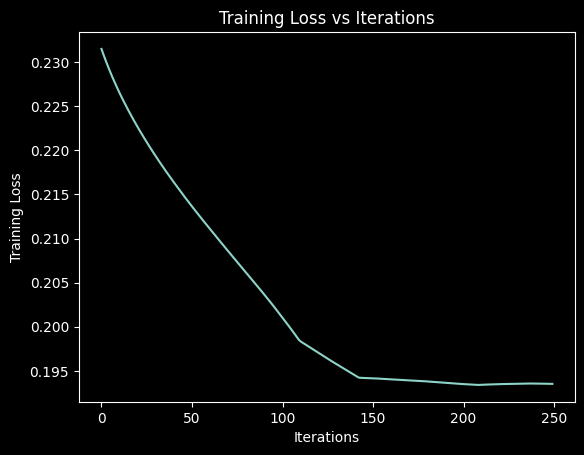

In [11]:
plt.plot(iter, nn1.loss)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title("Training Loss vs Iterations")
plt.show()

The Training Loss Graph shown is smooth, which means that the model is not overfitting. The model is able to learn the data and is able to generalize well.

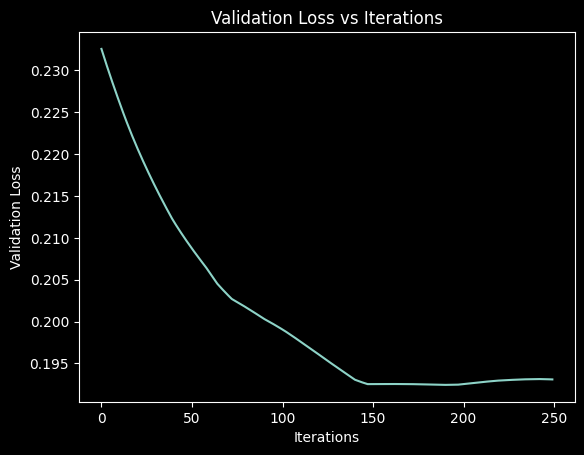

In [12]:
plt.plot(iter, nn1.val_loss)
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title("Validation Loss vs Iterations")
plt.show()

The Validation Loss Graph is also smooth, which means that the model is not overfitting. The model is able to learn the data and is able to generalize well, in case of validation test as well the model is showing great performance.

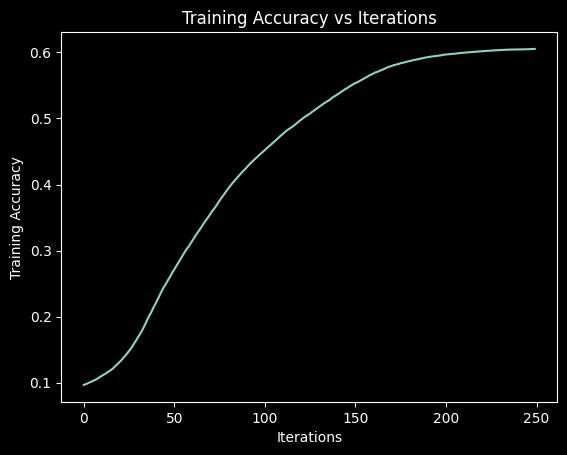

In [13]:
plt.plot(iter, nn1.accuracy)
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.title("Training Accuracy vs Iterations")
plt.show()

The accuracy, of the model is 0.60, which is satisfactory. The model is able to learn the data and is able to generalize well.

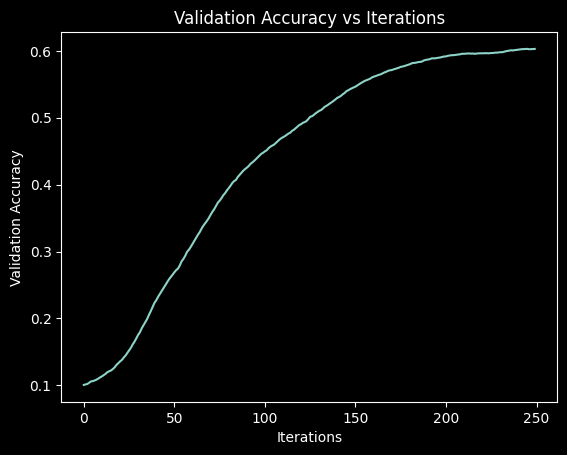

In [14]:
plt.plot(iter, nn1.val_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title("Validation Accuracy vs Iterations")
plt.show()

The accuracy, of the model is 0.60, which is satisfactory. The model is able to learn the data and is able to generalize well, in case of validation test as well the model is showing great performance.

# COMBINATION 2: SIGMOID + NORMAL

In [18]:
nn2 = NeuralNetwork(x_train.copy(), y_train.copy(), x_test, y_test, [128, 64], alpha=0.5, iterations=250, act='sigmoid', ini='normal')
nn2.gradient_descent()

Iteration: 1, Loss: 0.2341905873106793, Val Loss: 0.23317884452330082, Accuracy: 0.107
Iteration: 2, Loss: 0.23240723728619134, Val Loss: 0.2310370126915588, Accuracy: 0.11065
Iteration: 3, Loss: 0.23054283053029687, Val Loss: 0.22885889257838596, Accuracy: 0.11711666666666666
Iteration: 4, Loss: 0.22858208326311977, Val Loss: 0.22663670067706232, Accuracy: 0.12643333333333334
Iteration: 5, Loss: 0.22651811735943536, Val Loss: 0.22434351179424805, Accuracy: 0.13765
Iteration: 6, Loss: 0.22436103342628747, Val Loss: 0.2220404912053039, Accuracy: 0.15028333333333332
Iteration: 7, Loss: 0.22228085000863085, Val Loss: 0.21994474492468968, Accuracy: 0.16565
Iteration: 8, Loss: 0.2203306473308495, Val Loss: 0.2180070249372022, Accuracy: 0.18345
Iteration: 9, Loss: 0.2184842837358483, Val Loss: 0.21620121767219933, Accuracy: 0.20705
Iteration: 10, Loss: 0.21672713032504964, Val Loss: 0.214500853978635, Accuracy: 0.23228333333333334
Iteration: 11, Loss: 0.21516907615437314, Val Loss: 0.2128815

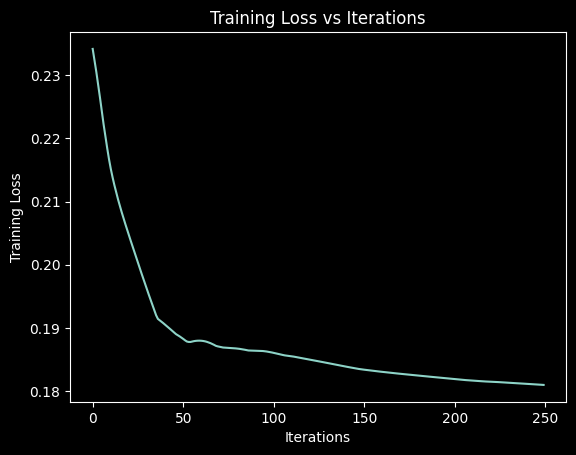

In [19]:
plt.plot(iter, nn2.loss)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title("Training Loss vs Iterations")
plt.show()

The Training Loss Graph shown is not as smootha as relu, which means that the model is not overfitting, however have some exceptions. The model is able to learn the data and is able to generalize well.

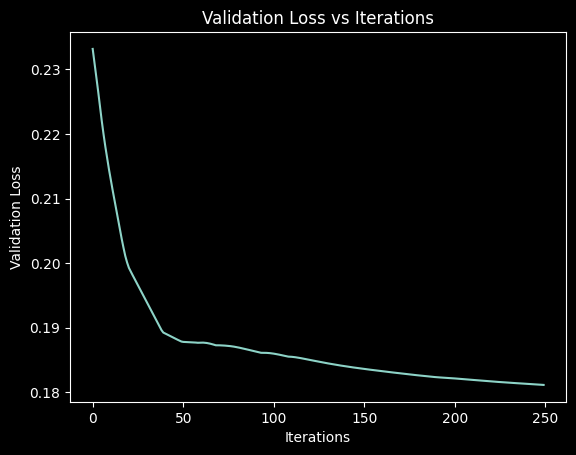

In [20]:
plt.plot(iter, nn2.val_loss)
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title("Validation Loss vs Iterations")
plt.show()

The validation loss graph is also not as smooth as relu, which means that the model is not overfitting, however have some exceptions. The model is able to learn the data and is able to generalize well, in case of validation test as well the model is showing great performance.

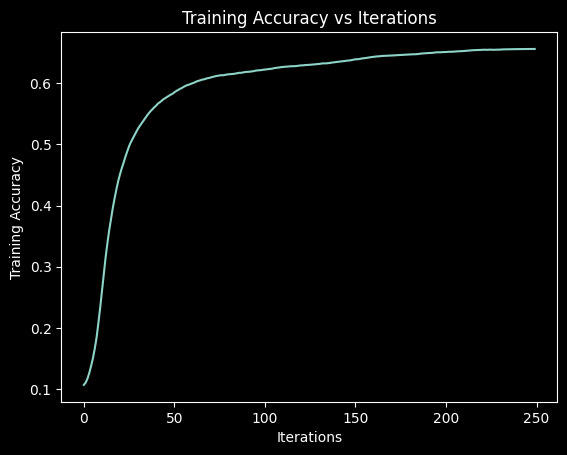

In [21]:
plt.plot(iter, nn2.accuracy)
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.title("Training Accuracy vs Iterations")
plt.show()

The accuracy of the model is 0.66, which is satisfactory. The model is able to learn the data and is able to generalize well.

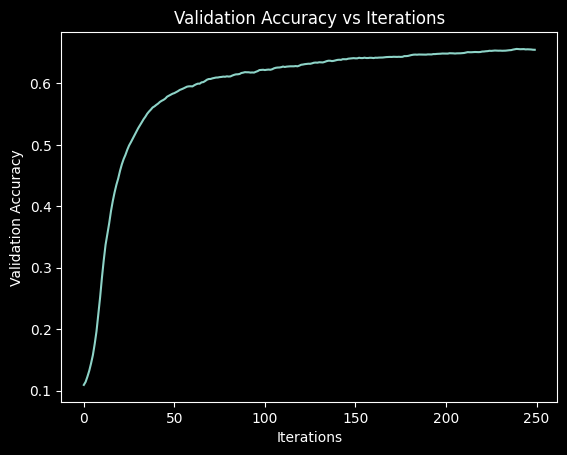

In [22]:
plt.plot(iter, nn2.val_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title("Validation Accuracy vs Iterations")
plt.show()

The validation accuracy of the model is 0.66, which is satisfactory. The model is able to learn the data and is able to generalize well, in case of validation test as well the model is showing great performance.

# COMBINATION 3: RELU + ZEROS

In [23]:
nn3 = NeuralNetwork(x_train.copy(), y_train.copy(), x_test, y_test, [128, 64], alpha=0.1, iterations=250, act='relu', ini='zeros')
nn3.gradient_descent()

Iteration: 1, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 2, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 3, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 4, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 5, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 6, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 7, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 8, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 9, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 10, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 11, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 12, Loss: 0.2302585092994045, Val Loss: 0.2302585092

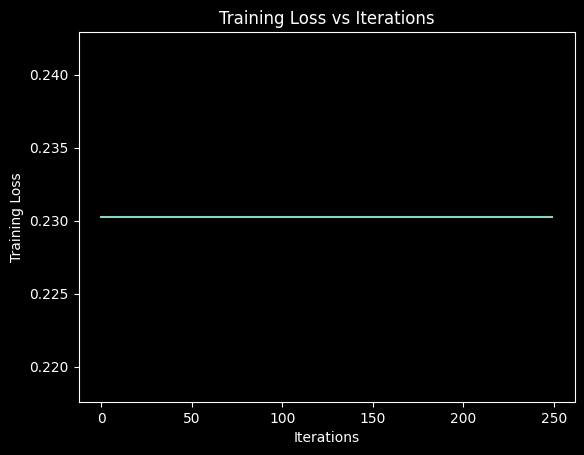

In [24]:
plt.plot(iter, nn3.loss)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title("Training Loss vs Iterations")
plt.show()

Since all the weights and bias, initialized with zeros, the model is not able to learn the data and is not able to generalize well. Thus giving the accuracy of 0.10.

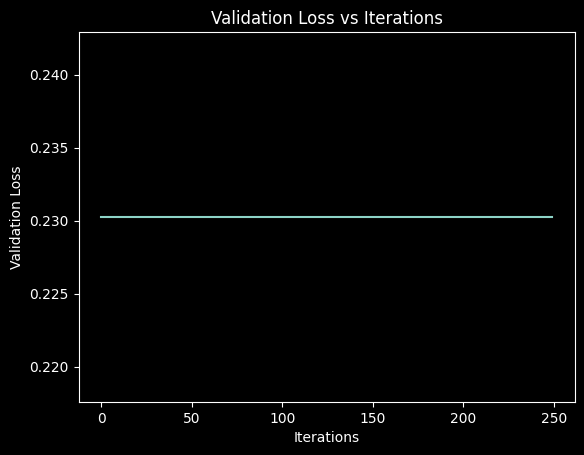

In [25]:
plt.plot(iter, nn3.val_loss)
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title("Validation Loss vs Iterations")
plt.show()

The same result as above, since all the weights and bias, initialized with zeros, the model is not able to learn the data and is not able to generalize well. Thus giving the accuracy of 0.10.

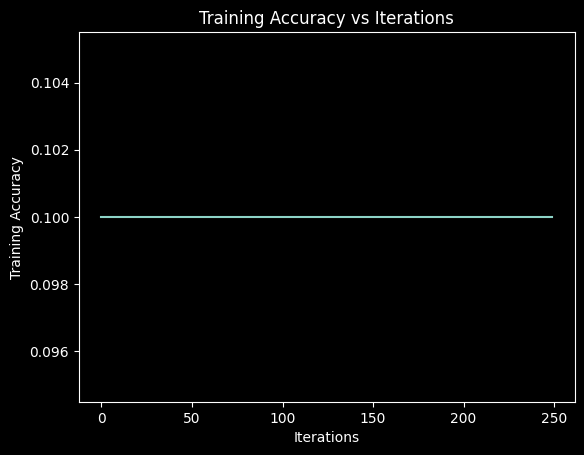

In [26]:
plt.plot(iter, nn3.accuracy)
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.title("Training Accuracy vs Iterations")
plt.show()

The model is not able to learn the data and is not able to generalize well. Thus giving the accuracy of 0.10.

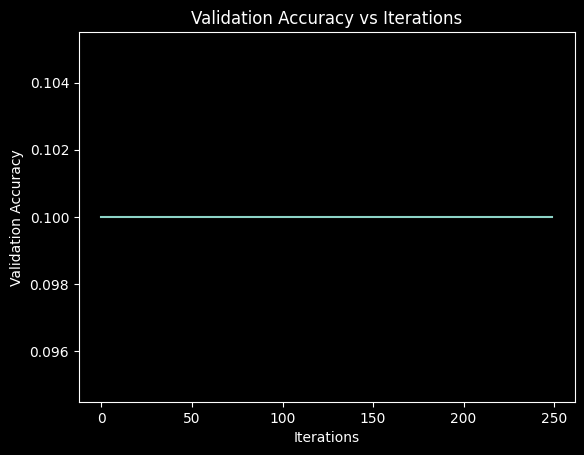

In [27]:
plt.plot(iter, nn3.val_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title("Validation Accuracy vs Iterations")
plt.show()

The same goes with the validation test, the model is not able to learn the data and is not able to generalize well. Thus giving the accuracy of 0.10.

# COMBINATION 4: SIGMOID + ZEROS

In [28]:
nn4 = NeuralNetwork(x_train.copy(), y_train.copy(), x_test, y_test, [128, 64], alpha=0.1, iterations=250, act='sigmoid', ini='zeros')
nn4.gradient_descent()

Iteration: 1, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 2, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 3, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 4, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 5, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 6, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 7, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 8, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 9, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 10, Loss: 0.2302585092994045, Val Loss: 0.23025850929940456, Accuracy: 0.1
Iteration: 11, Loss: 0.2302585092994045, Val Loss: 0.23025850929940458, Accuracy: 0.1
Iteration: 12, Loss: 0.2302585092994045, Val Loss: 0.2302585092

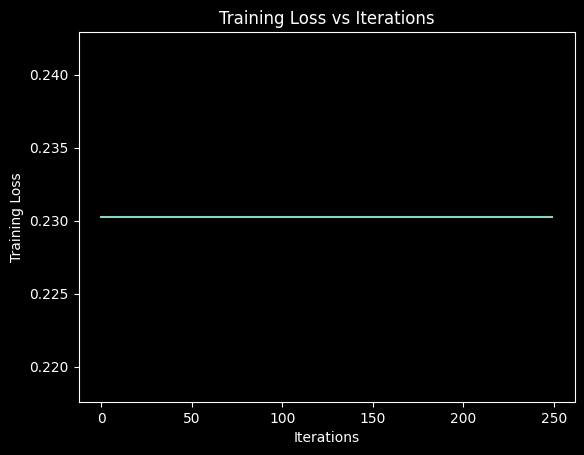

In [29]:
plt.plot(iter, nn4.loss)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title("Training Loss vs Iterations")
plt.show()

The result obtained is same as the above, since all the weights and bias, initialized with zeros, the model is not able to learn the data and is not able to generalize well. Thus giving the accuracy of 0.10.

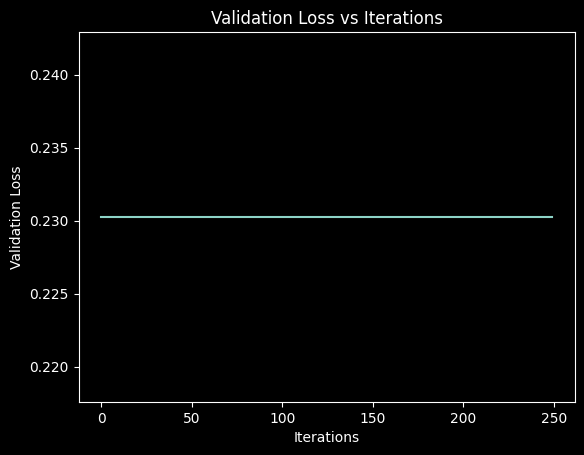

In [30]:
plt.plot(iter, nn4.val_loss)
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title("Validation Loss vs Iterations")
plt.show()

The result obtained is same as the above, since all the weights and bias, initialized with zeros, the model is not able to learn the data and is not able to generalize well. Thus giving the accuracy of 0.10.

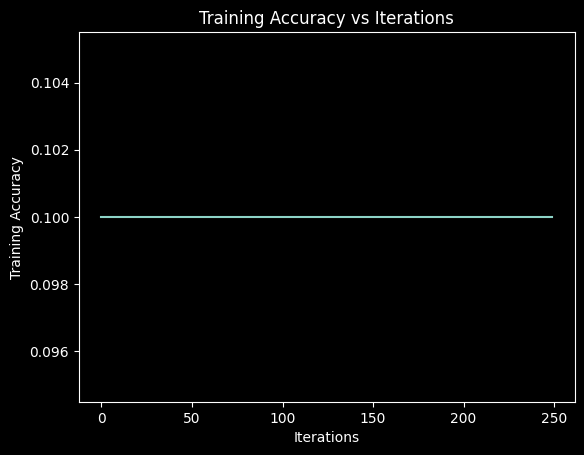

In [31]:
plt.plot(iter, nn4.accuracy)
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.title("Training Accuracy vs Iterations")
plt.show()

The result obtained is same as the above, since all the weights and bias, initialized with zeros, the model is not able to learn the data and is not able to generalize well. Thus giving the accuracy of 0.10.

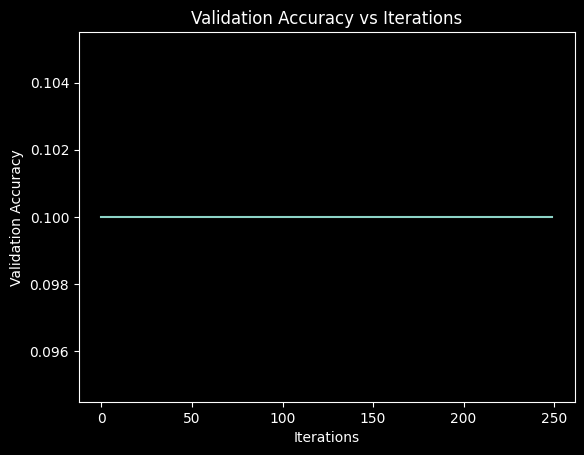

In [32]:
plt.plot(iter, nn4.val_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title("Validation Accuracy vs Iterations")
plt.show()

The result obtained is same as the above, since all the weights and bias, initialized with zeros, the model is not able to learn the data and is not able to generalize well. Thus giving the accuracy of 0.10.

The results obtained from the last two combinations is expected, since due to zero intitialization, the model is not able to learn the data. By initialzing the weights with zero the update parameters also became zero, which is not good for the model. Hence normal initialization is better than zero initialization.

Also __ReLU__ is better than __Sigmoid__, since relu is non-linear activation function, which is better than __Sigmoid__. __Sigmoid__ is a linear activation function, which is not good for the model. Also due to the non-linearity of __ReLU__, the model is able to learn the data and is able to generalize well, thus ginving us a smoother graph for loss as compared to signmoid.

# Saving the models

In [2]:
import os
import pickle

In [42]:
os.makedirs('models', exist_ok=True)
pickle.dump(nn1, open('models/relu_normal.pkl', 'wb'))

In [10]:
model = pickle.load(open('models/relu_normal.pkl', 'rb'))

In [15]:
model.get_accuracy(model.get_predictions(model.predit_proba(x_test)), y_test)

0.6028